In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
os.listdir('/content/drive/MyDrive/16000_pcm_speeches/audio')

['Nelson_Mandela',
 'Jens_Stoltenberg',
 'Julia_Gillard',
 'Magaret_Tarcher',
 'Benjamin_Netanyau']

In [2]:
features=[]
all_labels=[]

In [3]:
import glob
import librosa
import random
# spks=['Nelson_Mandela',
#  'Jens_Stoltenberg',
#  'Julia_Gillard',
#  'Magaret_Tarcher',
#  'Benjamin_Netanyau']
spks=['Nelson_Mandela',
 'Jens_Stoltenberg',
  'Julia_Gillard',
 'Magaret_Tarcher',
 'Benjamin_Netanyau'
]
for spk in spks:
  # audio_files=random.sample(glob.glob(f'/content/drive/MyDrive/16000_pcm_speeches/audio/{spk}/*.wav'),100)
  audio_files = glob.glob(f'/content/drive/MyDrive/16000_pcm_speeches/audio/{spk}/*.wav')
  print(len(audio_files))
  for au in audio_files:
    y,sr=librosa.load(au,sr=None)
    target_sr = 16000
    # y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
    mfcc = librosa.feature.mfcc(y=y, n_mfcc=13)
    mfcc.T
    features.append(mfcc.T)
    all_labels.append(spk)



1500
1500
1501
1500
1500


In [4]:
import numpy as np
np_features=np.array(features)
np_features.shape
all_labelsnp=np.array(all_labels)

In [5]:
print(np_features.shape)
print(all_labelsnp.shape)

(7501, 32, 13)
(7501,)


In [6]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
all_labels_np = label_encoder.fit_transform(all_labels)
all_labels_np = np.eye(len(label_encoder.classes_))[all_labels_np]
print(all_labels_np.shape)

(7501, 5)


In [7]:
import tensorflow as tf

def custom_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    Ptar = 0.01
    Cmiss = 1.0
    Cfa = 1.0

    Pmiss = tf.reduce_mean(y_true * (1 - y_pred))
    Pfa = tf.reduce_mean((1 - y_true) * y_pred)

    Cdet = Cmiss * Pmiss * Ptar + Cfa * Pfa * (1 - Ptar)

    return Cdet

# import tensorflow as tf

# def custom_loss(y_true, y_pred):
#     # Ensure y_true and y_pred are float32
#     y_true = tf.cast(y_true, tf.float32)
#     y_pred = tf.cast(y_pred, tf.float32)

#     # Parameters for detection cost function
#     Ptar = 0.01
#     Cmiss = 1.0
#     Cfa = 1.0

#     # Clip predictions to avoid log(0) or other instabilities
#     epsilon = 1e-8
#     y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

#     # Compute probabilities
#     Pmiss = tf.reduce_mean(y_true * (1 - y_pred))
#     Pfa = tf.reduce_mean((1 - y_true) * y_pred)

#     # Calculate detection cost
#     Cdet = Cmiss * Pmiss * Ptar + Cfa * Pfa * (1 - Ptar)

#     return Cdet



In [8]:
from tensorflow.keras.layers import Layer

class StatisticalPoolingLayer(Layer):
    def call(self, inputs):
        mean = tf.reduce_mean(inputs, axis=1)
        stddev = tf.math.reduce_std(inputs, axis=1)
        return tf.concat([mean, stddev], axis=1)


In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np_features, all_labels_np, test_size=0.2, random_state=42)
def StutterNet(input_shape, num_classes): # Add input_shape as a parameter
    input_layer = layers.Input(shape=input_shape) # Use input_shape for the input layer

    # Time Delay Layer 1: [t − 2, t + 2]
    x = layers.Conv1D(64, kernel_size=5, dilation_rate=1, padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Time Delay Layer 2: {t − 2, t, t + 2}
    x = layers.Conv1D(128, kernel_size=5, dilation_rate=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Time Delay Layer 3: {t − 3, t, t + 3}
    x = layers.Conv1D(256, kernel_size=7, dilation_rate=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Statistical Pooling: Combining Global Average Pooling and Global Max Pooling
    # avg_pool = layers.GlobalAveragePooling1D()(x)
    # max_pool = layers.GlobalMaxPooling1D()(x)
    # x = layers.concatenate([avg_pool, max_pool])
    x = StatisticalPoolingLayer()(x)

    # Fully Connected Layers
    x = layers.Dense(128)(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(64)(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.2)(x)

    # Output Layer
    output_layer = layers.Dense(num_classes)(x)
    output_layer = layers.Softmax()(output_layer)

    model = models.Model(inputs=input_layer, outputs=output_layer)

    return model

# Example usage:
# Assuming `num_classes` is defined based on your classification task
num_classes = 5  # Replace with the actual number of classes
input_shape = (32, 13) # Define the input shape based on your data
model = StutterNet(input_shape, num_classes) # Pass input_shape to the model

# Compile the model
model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])
history=model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))


# Print the model summary
model.summary()

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - accuracy: 0.7297 - loss: 0.0597 - val_accuracy: 0.8081 - val_loss: 0.0389
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9739 - loss: 0.0057 - val_accuracy: 0.9414 - val_loss: 0.0120
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9825 - loss: 0.0039 - val_accuracy: 0.9474 - val_loss: 0.0103
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9777 - loss: 0.0045 - val_accuracy: 0.9820 - val_loss: 0.0036
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9897 - loss: 0.0021 - val_accuracy: 0.9860 - val_loss: 0.0030
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9831 - loss: 0.0035 - val_accuracy: 0.9853 - val_loss: 0.0030
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9757 - loss: 0.0050 - val_accuracy: 0.8681 - val_loss: 0.0263
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9879 - loss: 0.0024 - val_accuracy: 0.9447 - val_lo

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32, 13)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 32, 64)              │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 32, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 32, 128)             │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_6 (ReLU)                       │ (None, 32, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 32, 256)             │         229,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_7 (ReLU)                       │ (None, 32, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ statistical_pooling_layer_1          │ (None, 512)                 │               0 │
│ (StatisticalPoolingLayer)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_8 (ReLU)                       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_9 (ReLU)                       │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             325 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_1 (Softmax)                  │ (None, 5)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 1,051,153 (4.01 MB)

 Trainable params: 350,085 (1.34 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 700,172 (2.67 MB)

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9457 - loss: 0.0111
Test accuracy: 0.9387075304985046


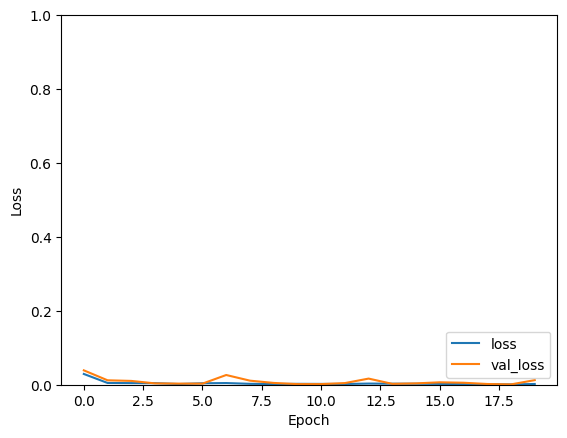

In [12]:
# Evaluating the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')

# Optionally: Plot training history to visualize loss and accuracy
import matplotlib.pyplot as plt

# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [13]:
model.save('/content/drive/MyDrive/tdnn_model/model_tdnn(5).keras')